In [25]:
import h5py
import numpy as  np
from pathlib import Path
import math
from source.preprocessHighFPS import _chunk_to_fft
import matplotlib.pyplot as plt

In [26]:
BASE_DIR = Path("D:/Studia/sium/semestr3/radar-project/data")  # change to your project dir

loaded_file = h5py.File(BASE_DIR/'dataset.h5','r')
frames = loaded_file['8']['dataset_8']
frames = frames[:,0,0,:]

In [27]:
print(frames.shape)

(19884, 512)


In [28]:
from source import helper

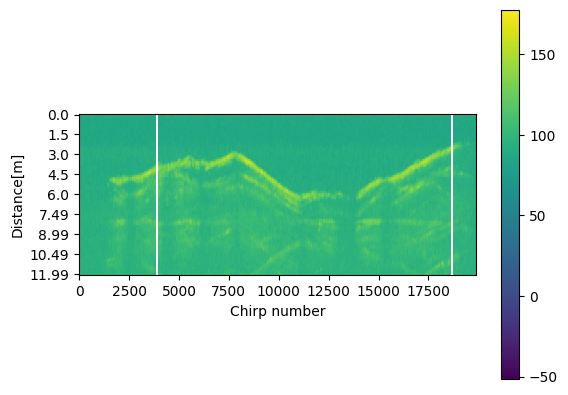

In [29]:
diff = helper.diff_frames(frames,  1)
distance_spect,y =  helper.gen_spectogram(diff)
distance_spect_db  = helper.to_dB(distance_spect)
helper.print_spectogram(distance_spect_db,y, 10,  12,100)

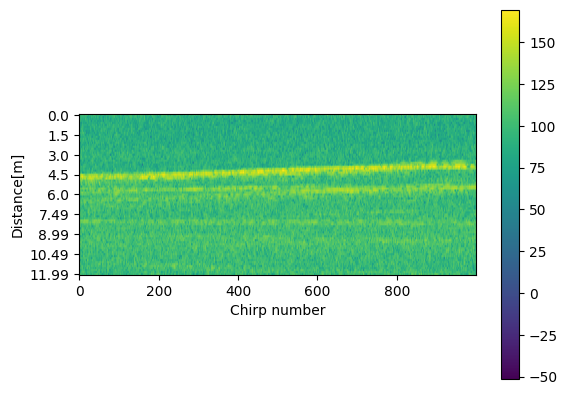

In [30]:
window = helper.get_window(diff,16000,1000)

distance_spect_window, y2 = helper.gen_spectogram(window)
distance_spect_window_db  = helper.to_dB(distance_spect_window)
helper.print_spectogram(distance_spect_window_db,y2, 10, 12,5)

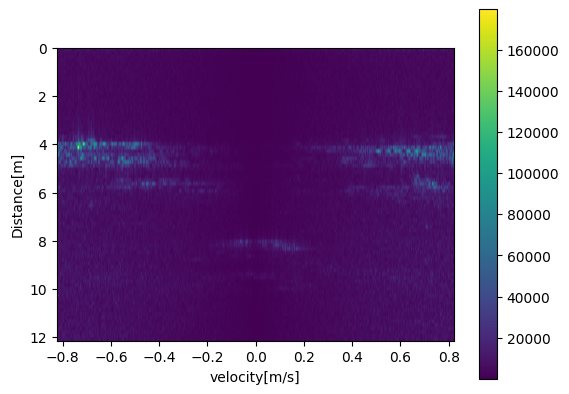

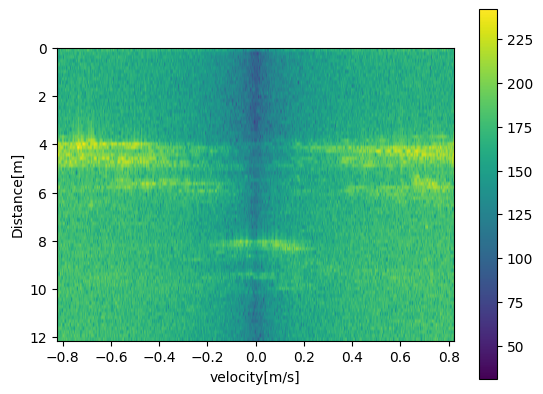

In [31]:
velocity_spect,y,x =  helper.gen_velocity_spectogram(window)
helper.print_vel_spectogram(velocity_spect,y,x,depth_limit=12, aspect=1/10)
velocity_spect_db = helper.to_dB(velocity_spect)
helper.print_vel_spectogram(velocity_spect_db,y,x,depth_limit=12, aspect=1/10)

co 10 klatke

In [34]:
frames = loaded_file['8']['dataset_8']
frames = frames[::10,0,0,:]

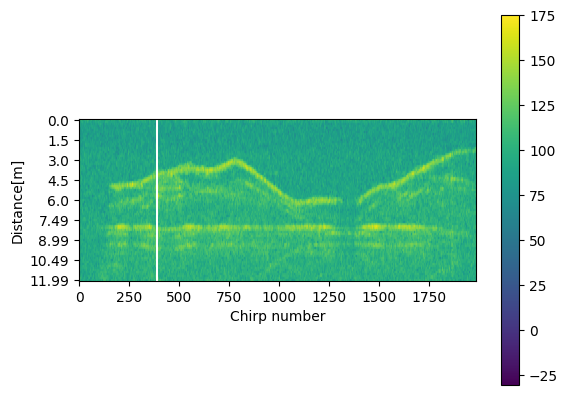

In [35]:
diff = helper.diff_frames(frames,  1)
distance_spect,y =  helper.gen_spectogram(diff)
distance_spect_db  = helper.to_dB(distance_spect)
helper.print_spectogram(distance_spect_db,y, 10,  12,10)

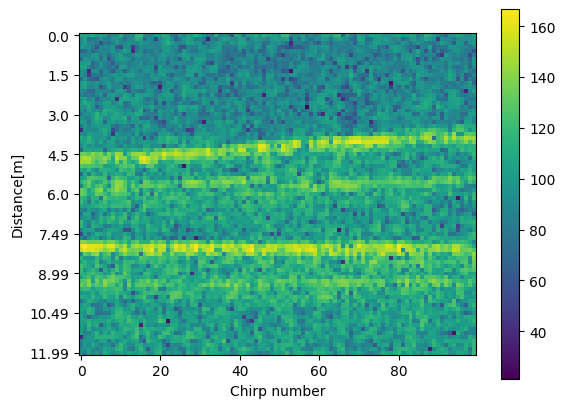

In [36]:
window = helper.get_window(diff,1600,100)

distance_spect_window, y2 = helper.gen_spectogram(window)
distance_spect_window_db  = helper.to_dB(distance_spect_window)
helper.print_spectogram(distance_spect_window_db,y2, 10, 12,1)

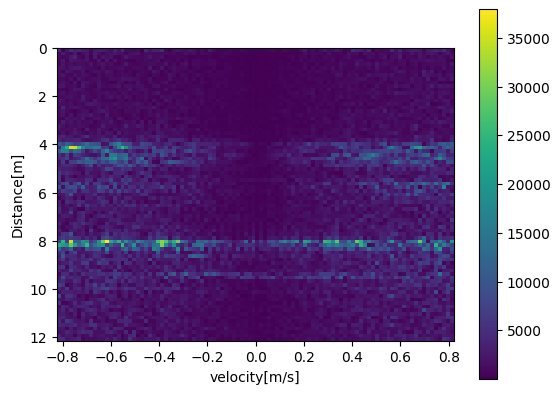

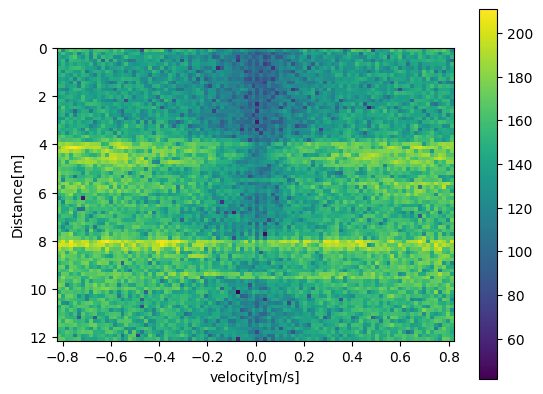

In [37]:
velocity_spect,y,x =  helper.gen_velocity_spectogram(window)
velocity_spect_db = helper.to_dB(velocity_spect)
helper.print_vel_spectogram(velocity_spect,y,x,depth_limit=12, aspect=1/10)
helper.print_vel_spectogram(velocity_spect_db,y,x,depth_limit=12, aspect=1/10)